In [1]:
import sys

In [2]:
sys.path.insert(0, '/home/joe2/Documents/LambdaSchool/labs_ir/repos/Data-Science/data')

In [3]:
sys.path

['/home/joe2/Documents/LambdaSchool/labs_ir/repos/Data-Science/data',
 '',
 '/home/joe2/anaconda3/envs/riskylobster/lib/python36.zip',
 '/home/joe2/anaconda3/envs/riskylobster/lib/python3.6',
 '/home/joe2/anaconda3/envs/riskylobster/lib/python3.6/lib-dynload',
 '/home/joe2/anaconda3/envs/riskylobster/lib/python3.6/site-packages',
 '/home/joe2/anaconda3/envs/riskylobster/lib/python3.6/site-packages/IPython/extensions',
 '/home/joe2/.ipython']

In [4]:
sys.path.remove('')

In [5]:
from fin_data import DailyTimeSeries
from fracdiff import FractionalDifferentiation as fd

import numpy as np
import pandas as pd
import os, sys
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.callbacks import ModelCheckpoint 

    
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout


pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

Using TensorFlow backend.


In [18]:
# Choose Company:
symbol = 'AAPL'

# Ininialize class
dts = DailyTimeSeries(symbol)

In [35]:
# Ininiate Dataframe

df = dts.initiate()
df.head()

################################################################### 
 Ticker:  AAPL 
 Last Refreshed:  2019-09-10 14:27:28 
 Data Retrieved:  Daily Time Series with Splits and Dividend Events 
 ###################################################################


,AAPL_open,AAPL_high,AAPL_low,AAPL_close,AAPL_adjusted_close,AAPL_volume,AAPL_dividend_amount
date,,,,,,,
1999-09-10,76.0000,77.688,74.688,77.438,2.4136,114690800.0,0.0
1999-09-13,77.0630,77.063,74.813,75.000,2.3376,63000000.0,0.0
1999-09-14,74.7190,78.500,74.688,77.813,2.4253,97073200.0,0.0
1999-09-15,78.8642,79.125,75.250,75.375,2.3493,89894000.0,0.0
1999-09-16,76.0630,78.063,73.875,76.813,2.3941,110471200.0,0.0


In [37]:
funs = ['totalrevenue',  'totalcostofrevenue', 'totalgrossprofit', 'totalpretaxincome', 'weightedavebasicdilutedsharesos', 'cashdividendspershare']
techs = ['SMA', 'WMA', 'STOCH', 'ROC', 'AROON']
macros = ['housing_index', 'confidence_index', 'trade_index', 'longterm_rates', 'shortterm_rates']

In [38]:
df = dts.add_fundamentals(df, funs)
df = dts.add_technicals(techs, df)
df = dts.add_macro(df, macros)

################################################################### 
 Ticker:  AAPL 
 Fundamentals Retrieved:  ['AAPL_open' 'AAPL_high' 'AAPL_low' 'AAPL_close' 'AAPL_adjusted_close'
 'AAPL_volume' 'AAPL_dividend_amount' 'AAPL_totalrevenue'
 'AAPL_totalcostofrevenue' 'AAPL_totalgrossprofit'
 'AAPL_totalpretaxincome' 'AAPL_weightedavebasicdilutedsharesos'
 'AAPL_cashdividendspershare'] 
 ###################################################################
################################################################### 
 Ticker:  AAPL 
 Retrieved Data Start Date:  2009-07-22 
 Retrieved Data End Date:  2019-07-31 
 Data Retrieved:  ['AAPL_totalrevenue', 'AAPL_totalcostofrevenue', 'AAPL_totalgrossprofit', 'AAPL_totalpretaxincome', 'AAPL_weightedavebasicdilutedsharesos', 'AAPL_cashdividendspershare'] 
 ###################################################################
################################################################### 
 Ticker:  AAPL 
 Last Refreshed:  Simple Moving Ave

/home/joe2/Documents/LambdaSchool/labs_ir/repos/Data-Science/data/fin_data.py:295: UserWarning: The latest value available for Housing Index is from January 2019.
  warnings.warn("The latest value available for Housing Index is from January 2019.")


################################################################### 
 Index: Yale Investor Behavior Project Added 
 ###################################################################
################################################################### 
 Trade Weighted U.S. Dollar Index: Broad Added 
 ###################################################################
################################################################### 
 US Treasury Bond Long-Term Rates Added 
 ###################################################################
################################################################### 
 US Treasury Bond Short-Term Rates Added 
 ###################################################################


/home/joe2/Documents/LambdaSchool/labs_ir/repos/Data-Science/data/fin_data.py:336: UserWarning: Contains Null Values
  warnings.warn("Contains Null Values")


In [39]:
todrop = []
for col in df.columns:
    if df[col].isnull().sum()/len(df) >  .1:
        todrop.append(col)

df = df.drop(labels=todrop, axis=1)
df = df.dropna(axis=0)

In [40]:
df.shape

(4299, 32)

In [41]:
df['target'] = fd.frac_diff_ffd(df[['AAPL_adjusted_close']], .35).shift(-1)['AAPL_adjusted_close']
#                          df['AAPL_adjusted_close']) / 
#                         (df['AAPL_adjusted_close']))*100


df['target']

df = df.dropna()

In [42]:
df.isnull().sum()

AAPL_open                               0
AAPL_high                               0
AAPL_low                                0
AAPL_close                              0
AAPL_adjusted_close                     0
AAPL_volume                             0
AAPL_dividend_amount                    0
AAPL_totalrevenue                       0
AAPL_totalcostofrevenue                 0
AAPL_totalgrossprofit                   0
AAPL_totalpretaxincome                  0
AAPL_weightedavebasicdilutedsharesos    0
AAPL_cashdividendspershare              0
AAPL_SMA                                0
AAPL_WMA                                0
AAPL_SlowK                              0
AAPL_SlowD                              0
AAPL_ROC                                0
AAPL_Aroon Up                           0
AAPL_Aroon Down                         0
housing_index                           0
conf_index                              0
conf_index_SE                           0
trade_value                       

In [43]:
X = df.drop(columns='target')
y = df[['target']].values

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=.8, 
                                                    shuffle=False)

In [45]:
scaler = MinMaxScaler()
scaler.fit(X_train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [46]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [58]:
train_data_generator = TimeseriesGenerator(X_train, y_train, 
                                           length=40,
                                           sampling_rate=1, 
                                           stride=1, 
                                           batch_size=20)

In [59]:
test_data_generator = TimeseriesGenerator(X_test, y_test, 
                                          length=40, 
                                          sampling_rate=1,
                                          stride=1,
                                          batch_size=20)

In [49]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [ ]:
model = Sequential()
model.add(LSTM(361, activation='relu', 
               return_sequences=True, 
               input_shape=(train_data_generator.length, 
                            X_train.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(196, return_sequences=True,
               activation='relu'))
model.add(Dropout(0.25))
model.add(LSTM(81, return_sequences=True,
               activation='relu'))
model.add(Dropout(0.25))
model.add(LSTM(64, activation='linear'))
model.add(Dropout(0.25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

checkpointer = ModelCheckpoint(filepath='weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5',
                               verbose=1, 
                               save_best_only=True)

callbacks_list = [checkpointer]

history_2 = model.fit_generator(train_data_generator, 
                                  epochs = 180,
                                  validation_data=test_data_generator,
                                  workers=-1,
                                  use_multiprocessing=True,
                                  verbose=1,
                                  callbacks=callbacks_list)

Epoch 1/180
97/97 [==============================] - 192s 2s/step - loss: 200.7306 - val_loss: 853461.4287

Epoch 00001: val_loss improved from inf to 853461.42871, saving model to weights-improvement-01-853461.43.hdf5
Epoch 2/180
97/97 [==============================] - 191s 2s/step - loss: 105.3564 - val_loss: 232.0912

Epoch 00002: val_loss improved from 853461.42871 to 232.09124, saving model to weights-improvement-02-232.09.hdf5
Epoch 3/180
97/97 [==============================] - 200s 2s/step - loss: 155.1270 - val_loss: 5757329.8295

Epoch 00003: val_loss did not improve from 232.09124
Epoch 4/180
97/97 [==============================] - 200s 2s/step - loss: 50.5572 - val_loss: 6237.7748

Epoch 00004: val_loss did not improve from 232.09124
Epoch 5/180
97/97 [==============================] - 194s 2s/step - loss: 16.2739 - val_loss: 625331903123.4890

Epoch 00005: val_loss did not improve from 232.09124
Epoch 6/180
97/97 [==============================] - 205s 2s/step - loss: 19

In [55]:
import matplotlib.pyplot as plt
# Plot training & validation loss values
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(0,100)
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


NameError: name 'history_2' is not defined

In [ ]:
#keep2
model = Sequential()
model.add(LSTM(128, activation='sigmoid', 
               return_sequences=True, 
               input_shape=(train_data_generator.length, 
                            X_train.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True,
               activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True,
               activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [ ]:
#keep3
model = Sequential()
model.add(LSTM(256, activation='relu', 
               return_sequences=True, 
               input_shape=(train_data_generator.length, 
                            X_train.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(144, return_sequences=True,
               activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(72, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [ ]:
#keep4

model = Sequential()
model.add(LSTM(361, activation='relu', 
               return_sequences=True, 
               input_shape=(train_data_generator.length, 
                            X_train.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(196, return_sequences=True,
               activation='relu'))
model.add(Dropout(0.25))
model.add(LSTM(81, return_sequences=True,
               activation='relu'))
model.add(Dropout(0.25))
model.add(LSTM(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1))

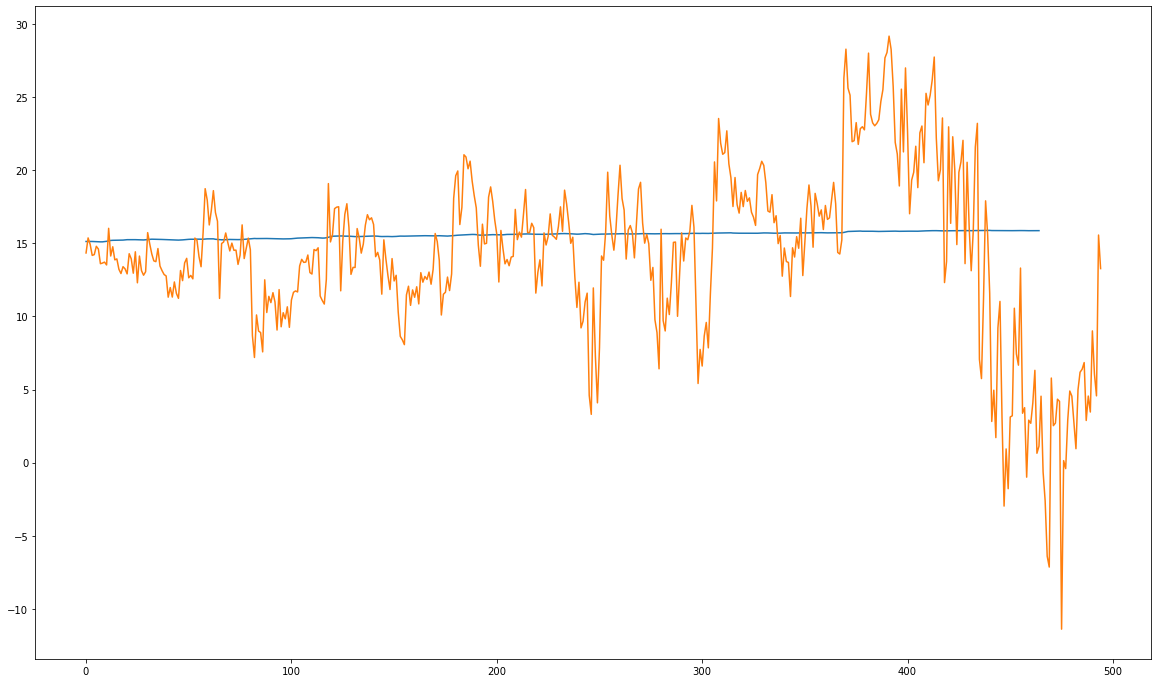

In [56]:
model.load_weights('weights-improvement-01-37.28.hdf5')

model.compile(optimizer='adam', loss='mse')

y_pred = model.predict_generator(test_data_generator)

plt.figure(figsize=(20,12))

plt.plot(y_pred)
plt.plot(y_test);

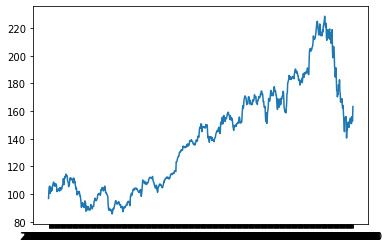

In [125]:
plt.plot(df['AAPL_adjusted_close'])

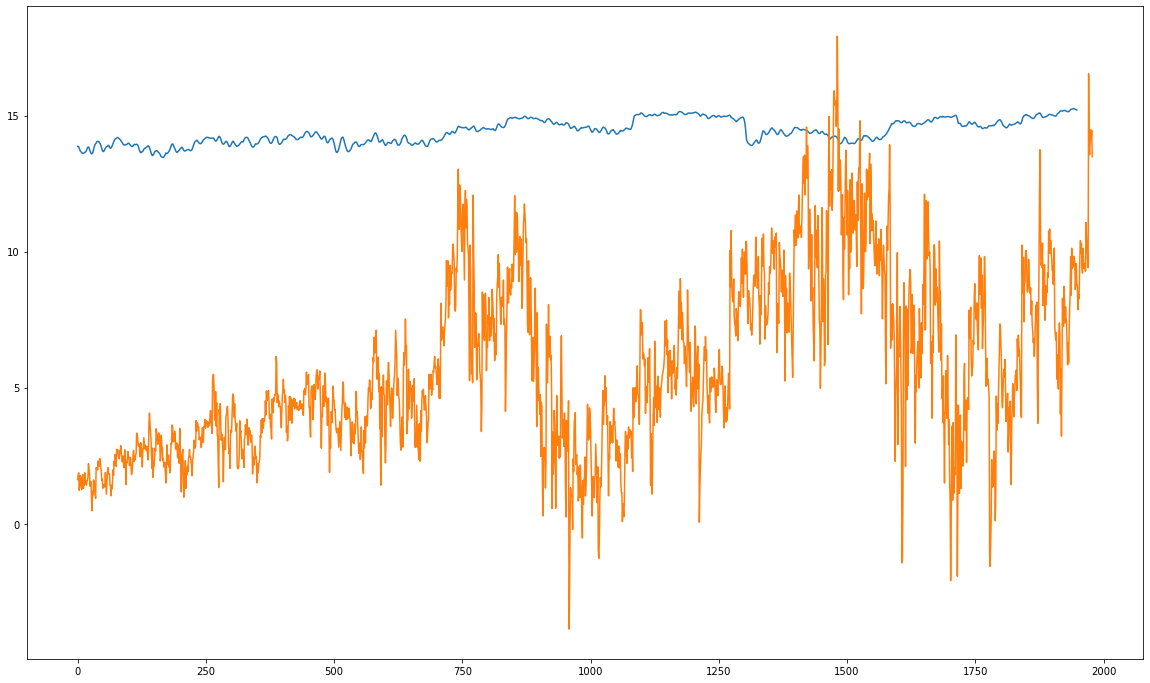

In [57]:
model.load_weights('weights-improvement-01-37.28.hdf5')

model.compile(optimizer='adam', loss='mse')

y_pred = model.predict_generator(train_data_generator)

plt.figure(figsize=(20,12))

plt.plot(y_pred)
plt.plot(y_train);